In [30]:
#impporting libries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import optimizers, losses, metrics


In [4]:
BATCH_SIZE=32
IMAGE_SIZE =256
CHANNELS=3
EPOCHS=10

In [5]:
dataset="chest_xray"

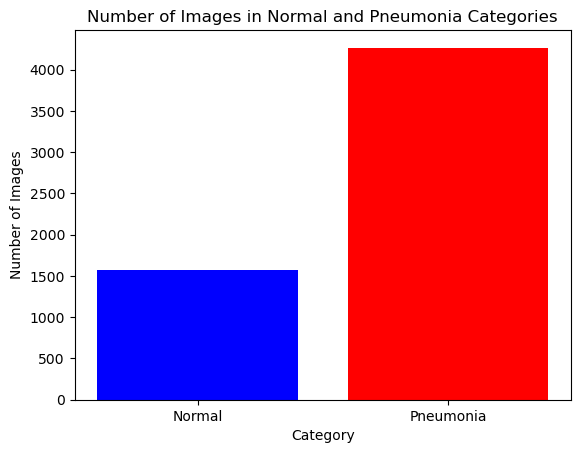

In [6]:
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                count += 1
    return count

input_dir_normal = r'C:\Users\Dell\Desktop\New folder (2)\chest_xray\NORMAL'
input_dir_pneumonia = r'C:\Users\Dell\Desktop\New folder (2)\chest_xray\PNEUMONIA'

# Count the images in each directory
count_normal = count_images(input_dir_normal)
count_pneumonia = count_images(input_dir_pneumonia)

# Plot the bar chart
labels = ['Normal', 'Pneumonia']
counts = [count_normal, count_pneumonia]

plt.bar(labels, counts, color=['blue', 'red'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images in Normal and Pneumonia Categories')
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [8]:
def resize_image(image_path, output_path, size=(256, 256)):
    try:
        with Image.open(image_path) as img:
            img = img.resize(size, Image.LANCZOS)
            img.save(output_path)
            print(f"Processed {image_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Directory containing the images
input_dir =dataset

# Process each image in the directory
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith(('.jpeg', '.jpg', '.png')):
            image_path = os.path.join(root, file)
            resize_image(image_path, image_path)

Processed chest_xray\NORMAL\IM-0001-0001.jpeg
Processed chest_xray\NORMAL\IM-0003-0001.jpeg
Processed chest_xray\NORMAL\IM-0005-0001.jpeg
Processed chest_xray\NORMAL\IM-0006-0001.jpeg
Processed chest_xray\NORMAL\IM-0007-0001.jpeg
Processed chest_xray\NORMAL\IM-0009-0001.jpeg
Processed chest_xray\NORMAL\IM-0010-0001.jpeg
Processed chest_xray\NORMAL\IM-0011-0001-0001.jpeg
Processed chest_xray\NORMAL\IM-0011-0001-0002.jpeg
Processed chest_xray\NORMAL\IM-0011-0001.jpeg
Processed chest_xray\NORMAL\IM-0013-0001.jpeg
Processed chest_xray\NORMAL\IM-0015-0001.jpeg
Processed chest_xray\NORMAL\IM-0016-0001.jpeg
Processed chest_xray\NORMAL\IM-0017-0001.jpeg
Processed chest_xray\NORMAL\IM-0019-0001.jpeg
Processed chest_xray\NORMAL\IM-0021-0001.jpeg
Processed chest_xray\NORMAL\IM-0022-0001.jpeg
Processed chest_xray\NORMAL\IM-0023-0001.jpeg
Processed chest_xray\NORMAL\IM-0025-0001.jpeg
Processed chest_xray\NORMAL\IM-0027-0001.jpeg
Processed chest_xray\NORMAL\IM-0028-0001.jpeg
Processed chest_xray\NOR

In [9]:
ds=tf.keras.preprocessing.image_dataset_from_directory(
    dataset,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)


Found 5840 files belonging to 2 classes.


In [10]:
class_names=ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [11]:
for image_batch, label_batch in ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels:", label_batch.numpy())

Image batch shape: (32, 256, 256, 3)
Labels: [1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1]


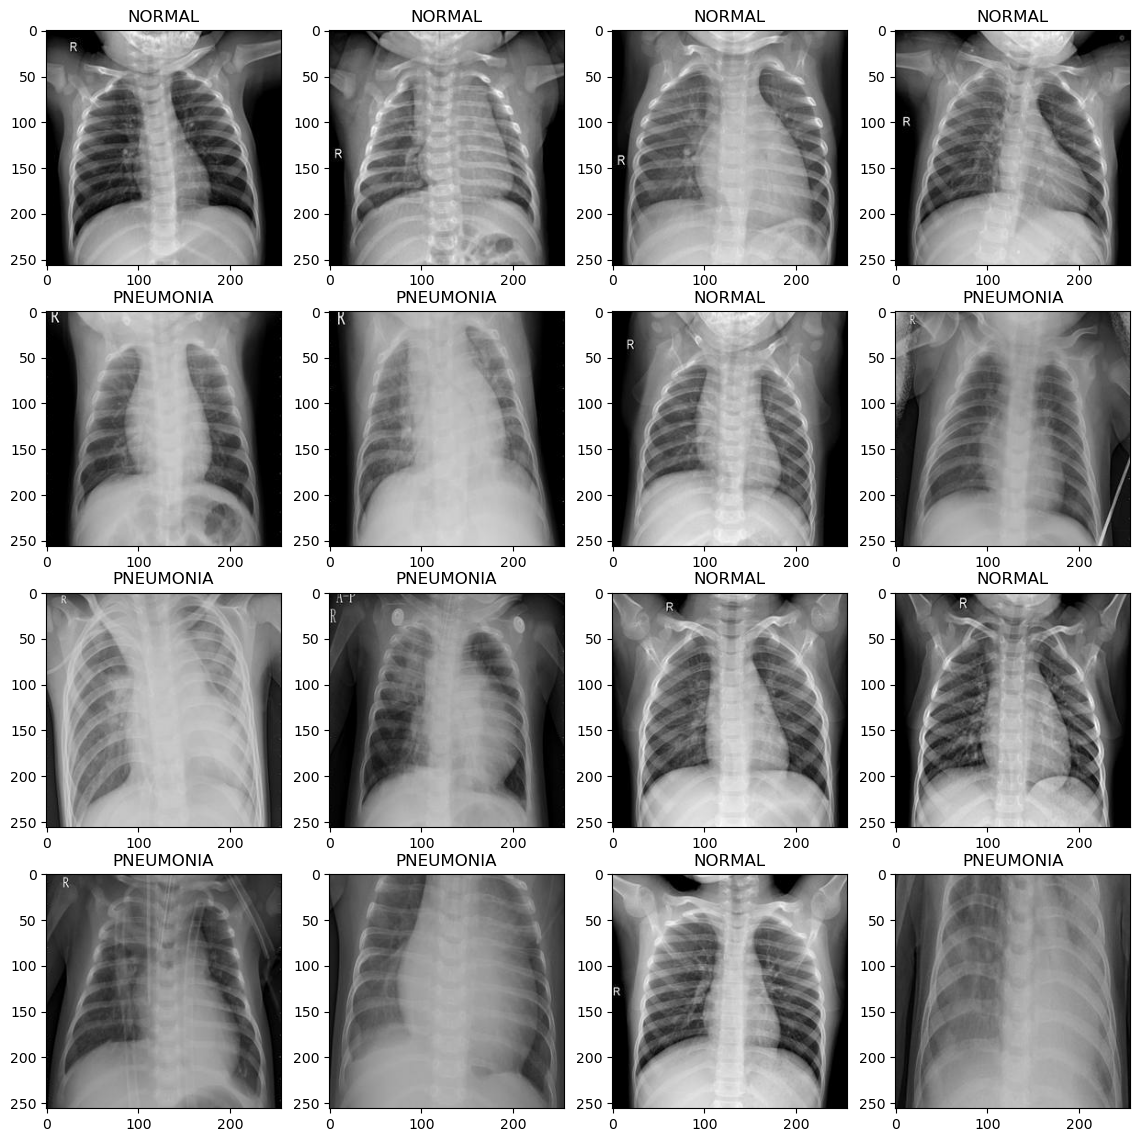

In [13]:
plt.figure(figsize=(14,14))
for image_batch ,label_batch in ds.take(1):
    for i in  range (16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow (image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        

In [14]:
num_batches = len(ds)
print(f"Number of batches: {num_batches}") 

Number of batches: 183


In [15]:
# Define the train, validation, and test sizes
train_size = 0.8
val_size = 0.1
test_size = 0.1  

In [16]:
# Calculate the number of batches for each split
num_train_batches = int(num_batches * train_size)  
num_val_batches = int(num_batches * val_size)     
num_test_batches = num_batches - num_train_batches - num_val_batches 

In [17]:
# Split the dataset
train_ds = ds.take(num_train_batches)
remaining_ds = ds.skip(num_train_batches)
val_ds = remaining_ds.take(num_val_batches)
test_ds = remaining_ds.skip(num_val_batches)

In [18]:
# Apply transformations
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
print(f"Number of train batches: {len(train_ds)}")  
print(f"Number of val batches: {len(val_ds)}")  
print(f"Number of test batches: {len(test_ds)}")  

Number of train batches: 146
Number of val batches: 18
Number of test batches: 19


In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

Data Augmentation
Data augmentation is a crucial technique employed to enhance the diversity of the training dataset in our pneumonia detection project. Instead of collecting new data, we apply various random transformations to the existing images. These transformations include rotating, flipping, zooming, and shifting the images. By doing so, we effectively increase the variability of the training data, which helps in improving the performance and robustness of our Convolutional Neural Network (CNN) model. This approach ensures that our model generalizes better to new, unseen data, ultimately leading to more accurate pneumonia detection.

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:

learning_rate = 0.001
model = models.Sequential([
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])



C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,617 (717.25 KB)

 Trainable params: 183,617 (717.25 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
adam_optimizer = optimizers.Adam(learning_rate=learning_rate)

In [44]:
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [39]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [45]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.6430 - loss: 2.1843 - val_accuracy: 0.7639 - val_loss: 0.5251 - learning_rate: 0.0010
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.7700 - loss: 0.5162 - val_accuracy: 0.8733 - val_loss: 0.3348 - learning_rate: 0.0010
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.8582 - loss: 0.3397 - val_accuracy: 0.8767 - val_loss: 0.3315 - learning_rate: 0.0010
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.8935 - loss: 0.2761 - val_accuracy: 0.8628 - val_loss: 0.3705 - learning_rate: 0.0010
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.8971 - loss: 0.2573 - val_accuracy: 0.9028 - val_loss: 0.2513 - learning_rate: 0.0010
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9005 - loss: 0.2516 - val_accuracy: 0.9167 - val_loss: 0.2248 - learning_rate: 0.0010
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.8998 - loss: 0.

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

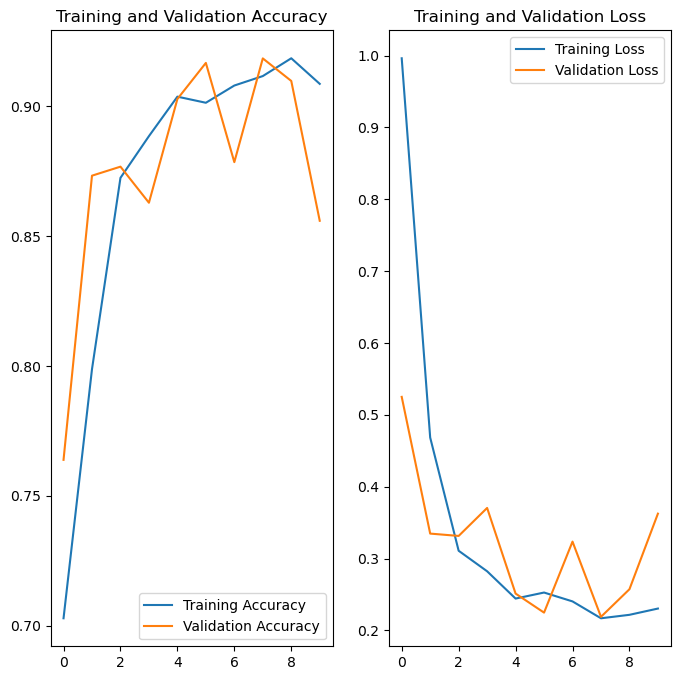

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:

learning_rate = 0.001

model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,206,341 (58.01 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 367,236 (1.40 MB)

In [56]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [54]:
model2.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [60]:
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/10


146/146 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.8138 - loss: 0.4587 - val_accuracy: 0.8125 - val_loss: 0.4506 - learning_rate: 0.0010
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.8257 - loss: 0.4165 - val_accuracy: 0.8108 - val_loss: 0.4498 - learning_rate: 0.0010
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.8311 - loss: 0.4151 - val_accuracy: 0.8125 - val_loss: 0.4650 - learning_rate: 0.0010
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.8268 - loss: 0.4079 - val_accuracy: 0.8056 - val_loss: 0.4625 - learning_rate: 0.0010
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.8182 - loss: 0.4227 - val_accuracy: 0.7882 - val_loss: 0.4793 - learning_rate: 0.0010
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.8215 - loss: 0.4068 - val_accuracy: 0.7986 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 519s 4s/step - accuracy: 0.8269 - loss: 0.4065 - val_

In [51]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [52]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(n_classes, activation='softmax')(x)


model2 = Model(inputs=base_model.input, outputs=predictions)


model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model2.summary()


C:\Users\Janith Manaranga\AppData\Local\Temp\ipykernel_23428\1176180533.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 128, 128, 32)      │             864 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 128, 128, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 128, 128, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 128, 128, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 128, 128, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 128, 128, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 128, 128, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 128, 128, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 128, 128, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 128, 128, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 128, 128, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 129, 129, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 64, 64, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,340,098 (8.93 MB)

 Trainable params: 82,114 (320.76 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [53]:
history_fine = model2.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)


Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 177s 756ms/step - accuracy: 0.8382 - loss: 0.3707 - val_accuracy: 0.9219 - val_loss: 0.1962
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 135s 684ms/step - accuracy: 0.9234 - loss: 0.1863 - val_accuracy: 0.9375 - val_loss: 0.1596
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 138s 696ms/step - accuracy: 0.9403 - loss: 0.1585 - val_accuracy: 0.9453 - val_loss: 0.1436
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 137s 693ms/step - accuracy: 0.9452 - loss: 0.1495 - val_accuracy: 0.9414 - val_loss: 0.1494
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 140s 707ms/step - accuracy: 0.9435 - loss: 0.1483 - val_accuracy: 0.9297 - val_loss: 0.1834
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 717ms/step - accuracy: 0.9447 - loss: 0.1373 - val_accuracy: 0.9570 - val_loss: 0.1506
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 145s 732ms/step - accuracy: 0.9550 - loss: 0.1295 - val_accuracy: 0.9518 - val_loss: 0.1466
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 156s 790ms/step - accuracy: 0.9502 -

In [59]:
history_fine2 = model2.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[early_stopping],
    verbose=1,
    epochs=20,
)


Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 152s 768ms/step - accuracy: 0.9592 - loss: 0.1139 - val_accuracy: 0.9570 - val_loss: 0.1183
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 149s 752ms/step - accuracy: 0.9527 - loss: 0.1144 - val_accuracy: 0.9544 - val_loss: 0.1168
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 153s 774ms/step - accuracy: 0.9577 - loss: 0.1033 - val_accuracy: 0.9479 - val_loss: 0.1303
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 140s 709ms/step - accuracy: 0.9620 - loss: 0.1041 - val_accuracy: 0.9596 - val_loss: 0.1175
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 717ms/step - accuracy: 0.9590 - loss: 0.0968 - val_accuracy: 0.9466 - val_loss: 0.1559


In [63]:
acc3 = history_fine.history['accuracy']
val_acc3 = history_fine.history['val_accuracy']

loss3 = history_fine.history['loss']
val_loss3 = history_fine.history['val_loss']

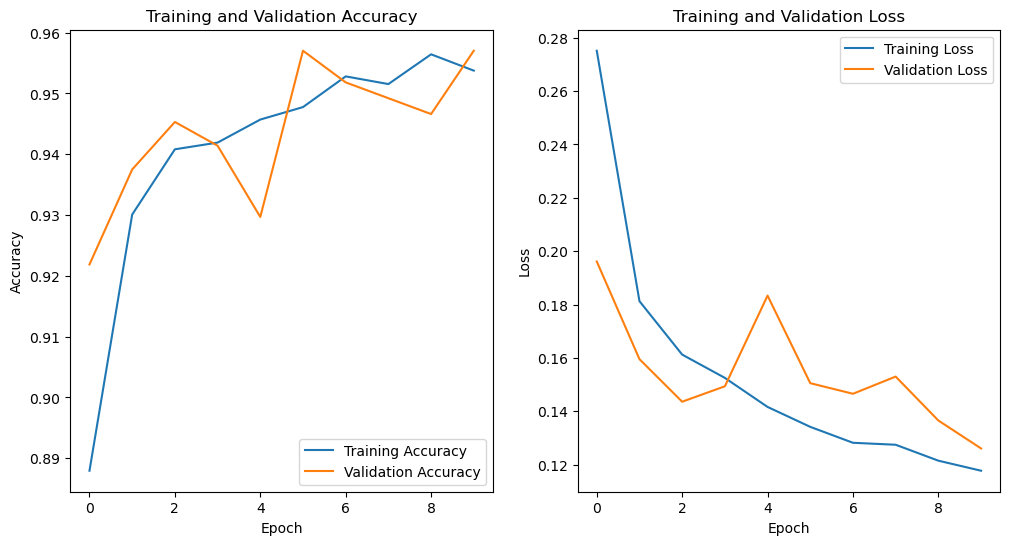

In [64]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(10), acc3, label='Training Accuracy')
plt.plot(range(10), val_acc3, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(10), loss3, label='Training Loss')
plt.plot(range(10), val_loss3, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [76]:
def predict(model2, img):
    # Ensure the image is in the correct shape and type
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

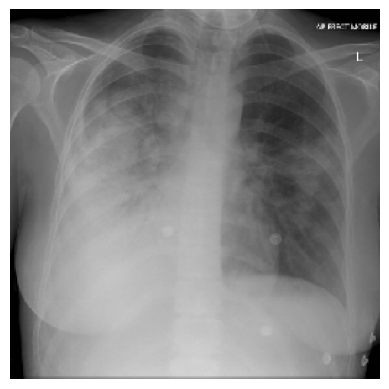

In [77]:
image_path = r'C:\Users\Janith Manaranga\Downloads\testp.png'

# Load and preprocess the image
img = load_img(image_path, target_size=(256, 256))  # Adjust target_size as per your model's input size

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [78]:
predicted_class, confidence = predict(model2, img)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted Class: NORMAL, Confidence: 99.71%


In [60]:
acc3 = history_fine2.history['accuracy']
val_acc3 = history_fine2.history['val_accuracy']

loss3 = history_fine2.history['loss']
val_loss3 = history_fine2.history['val_loss']

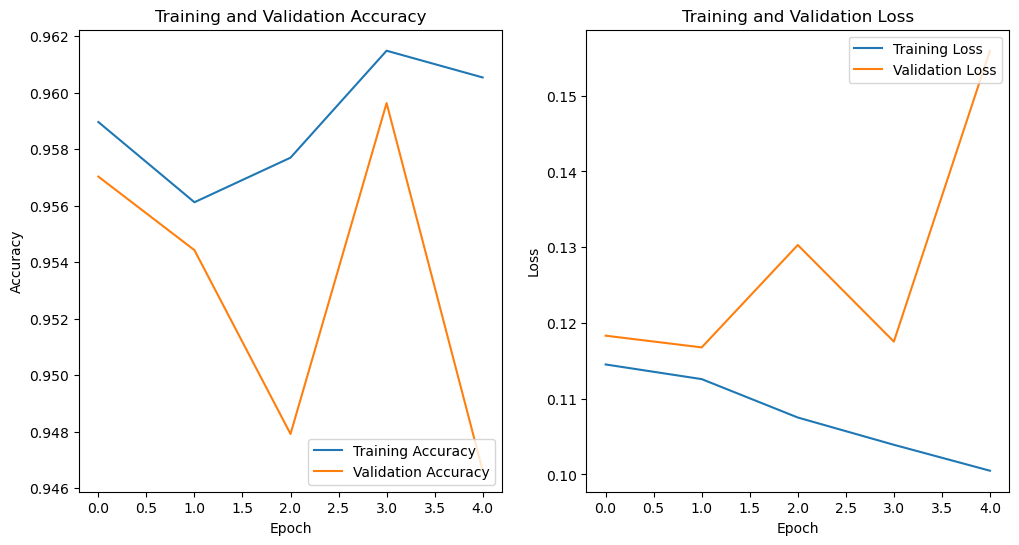

In [62]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(5), acc3, label='Training Accuracy')
plt.plot(range(5), val_acc3, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(5), loss3, label='Training Loss')
plt.plot(range(5), val_loss3, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [46]:
history_fine_2 = model2.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)


Epoch 1/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 126s 680ms/step - accuracy: 0.9498 - loss: 0.1242 - val_accuracy: 0.9606 - val_loss: 0.1183
Epoch 2/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 122s 661ms/step - accuracy: 0.9549 - loss: 0.1214 - val_accuracy: 0.9647 - val_loss: 0.1294
Epoch 3/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 123s 664ms/step - accuracy: 0.9523 - loss: 0.1242 - val_accuracy: 0.9579 - val_loss: 0.1214
Epoch 4/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 122s 660ms/step - accuracy: 0.9554 - loss: 0.1143 - val_accuracy: 0.9497 - val_loss: 0.1310
Epoch 5/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 122s 661ms/step - accuracy: 0.9598 - loss: 0.1053 - val_accuracy: 0.9606 - val_loss: 0.1274
Epoch 6/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 122s 659ms/step - accuracy: 0.9524 - loss: 0.1167 - val_accuracy: 0.9565 - val_loss: 0.1178
Epoch 7/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 124s 668ms/step - accuracy: 0.9545 - loss: 0.1126 - val_accuracy: 0.9606 - val_loss: 0.1221
Epoch 8/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 124s 669ms/step - accuracy: 0.9621 -

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to be monitored
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [39]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stopping],  # Include the callback in the training process
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9660 - val_loss: 0.1520
Epoch 2/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9715 - val_loss: 0.2010
Epoch 3/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9973 - loss: 0.0098 - val_accuracy: 0.9701 - val_loss: 0.1008
Epoch 4/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.9935 - loss: 0.0158 - val_accuracy: 0.9647 - val_loss: 0.1281
Epoch 5/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.9936 - loss: 0.0155 - val_accuracy: 0.9742 - val_loss: 0.1214
Epoch 6/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.9988 - loss: 0.0026 - val_accuracy: 0.9728 - val_loss: 0.1435


In [49]:
acc2 = history_fine_2.history['accuracy']
val_acc2 = history_fine_2.history['val_accuracy']

loss2 = history_fine_2.history['loss']
val_loss2 = history_fine_2.history['val_loss']

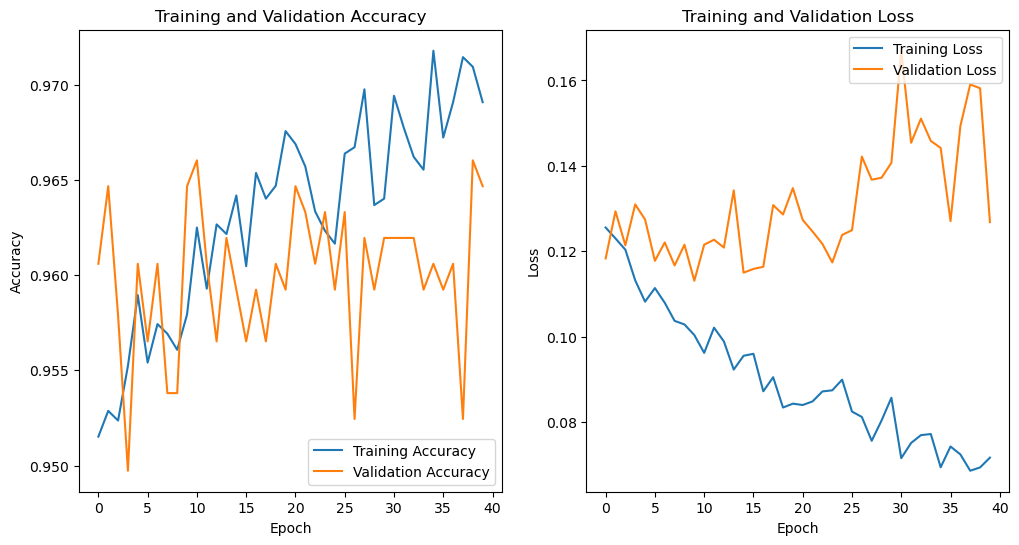

In [51]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(40), acc2, label='Training Accuracy')
plt.plot(range(40), val_acc2, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(40), loss2, label='Training Loss')
plt.plot(range(40), val_loss2, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [52]:
def predict(model2, img):
    # Ensure the image is in the correct shape and type
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence


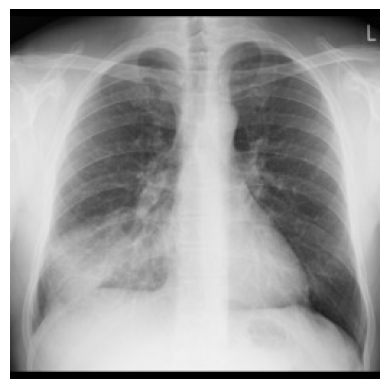

In [59]:
image_path = r'C:\Users\Janith Manaranga\Downloads\tt.jpeg'

# Load and preprocess the image
img = load_img(image_path, target_size=(256, 256))  # Adjust target_size as per your model's input size

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [60]:
predicted_class, confidence = predict(model2, img)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Class: NORMAL, Confidence: 100.0%


Project Summary: Pneumonia Detection using Convolutional Neural Networks
In this project, we developed a Convolutional Neural Network (CNN) model to detect pneumonia from chest X-ray images. The primary goal was to build a model that accurately distinguishes between pneumonia-infected lungs and normal lungs.

Data Augmentation
To enhance the diversity of our training dataset and improve model generalization, we applied data augmentation techniques. These techniques included random rotations, flips, zooms, and shifts, effectively creating varied versions of the existing images without needing to collect new data. This step was crucial in preventing overfitting and ensuring that the model performs well on unseen data.

Model Architecture
The CNN architecture was designed with multiple convolutional layers to extract features from the images, followed by max-pooling layers to reduce dimensionality and computational complexity. The model includes several Conv2D layers with ReLU activation functions, and a final dense layer with a sigmoid activation to output the probability of pneumonia presence.

Learning Rate and Regularization
We used the Adam optimizer with a learning rate of 0.001, along with L2 regularization in some convolutional layers to prevent overfitting. Regularization helps by penalizing large weights, thus encouraging the model to learn simpler patterns that generalize better.

Training and Results
The model was trained on a dataset of 5840 images for 10 epochs. During training, we monitored the validation accuracy and loss to ensure that the model was not overfitting. Our chosen architecture showed a continuous drop in validation loss and an increase in validation accuracy, indicating that the model was learning effectively and generalizing well to the validation data.

Conclusion
This project successfully developed a robust model for pneumonia detection, demonstrating the importance of data augmentation, appropriate model architecture, and regularization techniques in achieving high performance. The validation metrics provided confidence that the model could be a valuable tool in aiding the diagnosis of pneumonia from chest X-ray images.